# Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import matplotlib
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
from natsort import natsorted
from itertools import combinations
from scipy.stats import ttest_ind, f_oneway
from statsmodels.stats.multitest import multipletests

import OncoMark as oma

# Plot setting

In [3]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2024-04-11 11:47:55|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

In [4]:
## Read HLAs
HLAs = pd.read_csv("../OncoMark/data/datasets/OptiTypeCallsHLA_20171207.tsv", index_col=8)
HLAs.index = ["-".join(idx.split("-")[:3]) for idx in HLAs.index]
HLAs = HLAs.iloc[:, :6]
HLAs = HLAs.rename_axis("submitter_id").reset_index().drop_duplicates().set_index("submitter_id")
HLAs["A"] = [[a1.split(":")[0], a2.split(":")[0]] for a1, a2 in HLAs[["A1", "A2"]].values]

In [5]:
frac = HLAs[["A"]].explode("A").reset_index().drop_duplicates().groupby("A").size().sort_values(ascending=False) / HLAs.index.nunique()
frac = frac.to_frame("percentage")
frac["%"] = round(frac*100, 1)
frac["allotypes"] = frac.index.astype(str) + " (" + frac["%"].astype(str) + "%)"

In [6]:
frac

,percentage,%,allotypes
A,,,
A*02,0.472462,47.2,A*02 (47.2%)
A*01,0.239596,24.0,A*01 (24.0%)
A*03,0.237016,23.7,A*03 (23.7%)
A*24,0.178800,17.9,A*24 (17.9%)
A*11,0.124621,12.5,A*11 (12.5%)
A*68,0.086932,8.7,A*68 (8.7%)
A*30,0.074481,7.4,A*30 (7.4%)
A*29,0.066517,6.7,A*29 (6.7%)
A*26,0.063264,6.3,A*26 (6.3%)


In [7]:
patient_data_TCGA_tumor = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                             metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                             filter_samples=100, sample_type="Tumor", genes=["IGSF8", "KIR3DL2"])
IGSF8_tumor = patient_data_TCGA_tumor.to_df().join(patient_data_TCGA_tumor.obs[["project_id","submitter_id", "samples.sample_type"]])
IGSF8_tumor = IGSF8_tumor[~IGSF8_tumor['project_id'].isin(['LAML', "DLBC"])].set_index("submitter_id")

2024-04-11 11:47:55|INFO|dataloader|Dropping duplicates...
2024-04-11 11:47:55|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-04-11 11:47:55|INFO|dataloader|Take Tumor samples only.
2024-04-11 11:47:55|INFO|dataloader|Take gene expression data of ['IGSF8', 'KIR3DL2']
2024-04-11 11:47:55|INFO|dataloader|Filtering out patients with < 100 samples...


In [8]:
HLA_A_IGSF8 = HLAs[["A"]].explode("A").join(IGSF8_tumor).dropna()
HLA_A_IGSF8["A"] = [a.split(":")[0] for a in HLA_A_IGSF8["A"]]
HLA_A_IGSF8 = HLA_A_IGSF8[HLA_A_IGSF8["A"].isin(frac.index[:10])]
HLA_A_IGSF8["allotypes"] = HLA_A_IGSF8["A"].map(frac["allotypes"])

In [9]:
HLA_A_IGSF8

,A,IGSF8,KIR3DL2,project_id,samples.sample_type,allotypes
submitter_id,,,,,,
TCGA-DD-A1EI,A*30,5.813481,0.000000,LIHC,Primary Tumor,A*30 (7.4%)
TCGA-39-5022,A*01,6.606223,1.541534,LUSC,Primary Tumor,A*01 (24.0%)
TCGA-39-5022,A*03,6.606223,1.541534,LUSC,Primary Tumor,A*03 (23.7%)
TCGA-KK-A7B1,A*11,7.171507,0.165151,PRAD,Primary Tumor,A*11 (12.5%)
TCGA-KK-A7B1,A*11,7.171507,0.165151,PRAD,Primary Tumor,A*11 (12.5%)
...,...,...,...,...,...,...
TCGA-D8-A140,A*30,8.569019,0.066802,BRCA,Primary Tumor,A*30 (7.4%)
TCGA-D8-A140,A*11,8.569019,0.066802,BRCA,Primary Tumor,A*11 (12.5%)
TCGA-B5-A1MY,A*02,7.164939,0.447225,UCEC,Primary Tumor,A*02 (47.2%)


In [10]:
grouped = HLA_A_IGSF8.groupby(['A'])
tstat_results = pd.DataFrame(index=grouped["A"].count().index, columns=["tstat", "pvalue"])
for idx,row in tstat_results.iterrows():
    tstat, p_value = ttest_ind(HLA_A_IGSF8.query('A==@idx')["IGSF8"].values, HLA_A_IGSF8.query('A!=@idx')["IGSF8"].values)
    tstat_results.loc[idx, "tstat"] = tstat
    tstat_results.loc[idx, "pvalue"] = p_value
tstat_results.loc[:, "adj.pval"] = multipletests(tstat_results.loc[:, "pvalue"], method='fdr_bh', alpha=0.05)[1]

In [11]:
tstat_results

,tstat,pvalue,adj.pval
A,,,
A*01,-2.013899,0.044038,0.202954
A*02,0.910498,0.362574,0.725149
A*03,0.228137,0.819542,0.933526
A*11,-0.623548,0.532934,0.888223
A*24,-1.321048,0.186505,0.466263
A*26,-0.188116,0.850788,0.933526
A*29,-0.092469,0.926327,0.933526
A*30,1.874459,0.060886,0.202954
A*32,-0.083411,0.933526,0.933526


In [12]:
tstat_results = tstat_results[tstat_results["adj.pval"] < 0.05]
tstat_results

,tstat,pvalue,adj.pval
A,,,


In [13]:
HLA_A_IGSF8

,A,IGSF8,KIR3DL2,project_id,samples.sample_type,allotypes
submitter_id,,,,,,
TCGA-DD-A1EI,A*30,5.813481,0.000000,LIHC,Primary Tumor,A*30 (7.4%)
TCGA-39-5022,A*01,6.606223,1.541534,LUSC,Primary Tumor,A*01 (24.0%)
TCGA-39-5022,A*03,6.606223,1.541534,LUSC,Primary Tumor,A*03 (23.7%)
TCGA-KK-A7B1,A*11,7.171507,0.165151,PRAD,Primary Tumor,A*11 (12.5%)
TCGA-KK-A7B1,A*11,7.171507,0.165151,PRAD,Primary Tumor,A*11 (12.5%)
...,...,...,...,...,...,...
TCGA-D8-A140,A*30,8.569019,0.066802,BRCA,Primary Tumor,A*30 (7.4%)
TCGA-D8-A140,A*11,8.569019,0.066802,BRCA,Primary Tumor,A*11 (12.5%)
TCGA-B5-A1MY,A*02,7.164939,0.447225,UCEC,Primary Tumor,A*02 (47.2%)


# Split patients by A*03/11

In [14]:
## Read HLAs
HLAs = pd.read_csv("../OncoMark/data/datasets/OptiTypeCallsHLA_20171207.tsv", index_col=8)
HLAs.index = ["-".join(idx.split("-")[:3]) for idx in HLAs.index]
HLAs = HLAs.iloc[:, :2]
HLAs["A1"] = [a1.split(":")[0] for a1 in HLAs["A1"].values]
HLAs["A2"] = [a1.split(":")[0] for a1 in HLAs["A2"].values]

HLAs = HLAs.rename_axis("submitter_id").reset_index().drop_duplicates().set_index("submitter_id")
HLAs["A"] = [natsorted([a1, a2]) if a1!=a2 else [a1]
             for a1, a2 in HLAs[["A1", "A2"]].values]
HLAs = HLAs.loc[~HLAs.index.duplicated()]

In [15]:
HLA_A03_mask = (HLAs[["A1", "A2"]] == "A*03").sum(axis=1)>0
HLA_A11_mask = (HLAs[["A1", "A2"]] == "A*11").sum(axis=1)>0

HLA_A_IGSF8["A*03/11"] = HLA_A_IGSF8.index.map(HLA_A11_mask | HLA_A03_mask)
HLA_A_IGSF8["A*03/11"] = HLA_A_IGSF8["A*03/11"].replace(True, "positive").replace(False, "negative")

In [16]:
HLA_A_IGSF8 = HLA_A_IGSF8.loc[HLA_A_IGSF8.index.duplicated()]

In [17]:
HLA_A_IGSF8

,A,IGSF8,KIR3DL2,project_id,samples.sample_type,allotypes,A*03/11
submitter_id,,,,,,,
TCGA-39-5022,A*03,6.606223,1.541534,LUSC,Primary Tumor,A*03 (23.7%),positive
TCGA-KK-A7B1,A*11,7.171507,0.165151,PRAD,Primary Tumor,A*11 (12.5%),positive
TCGA-DD-AAW2,A*26,7.538435,0.199111,LIHC,Primary Tumor,A*26 (6.3%),negative
TCGA-EL-A3MX,A*02,7.951256,0.000000,THCA,Primary Tumor,A*02 (47.2%),negative
TCGA-O1-A52J,A*02,6.542970,0.384376,LUAD,Primary Tumor,A*02 (47.2%),negative
...,...,...,...,...,...,...,...
TCGA-J8-A3O0,A*01,7.041353,0.085838,THCA,Primary Tumor,A*01 (24.0%),positive
TCGA-AA-3693,A*03,6.975389,0.000000,COAD,Primary Tumor,A*03 (23.7%),positive
TCGA-CV-6950,A*29,6.498040,0.035469,HNSC,Primary Tumor,A*29 (6.7%),negative


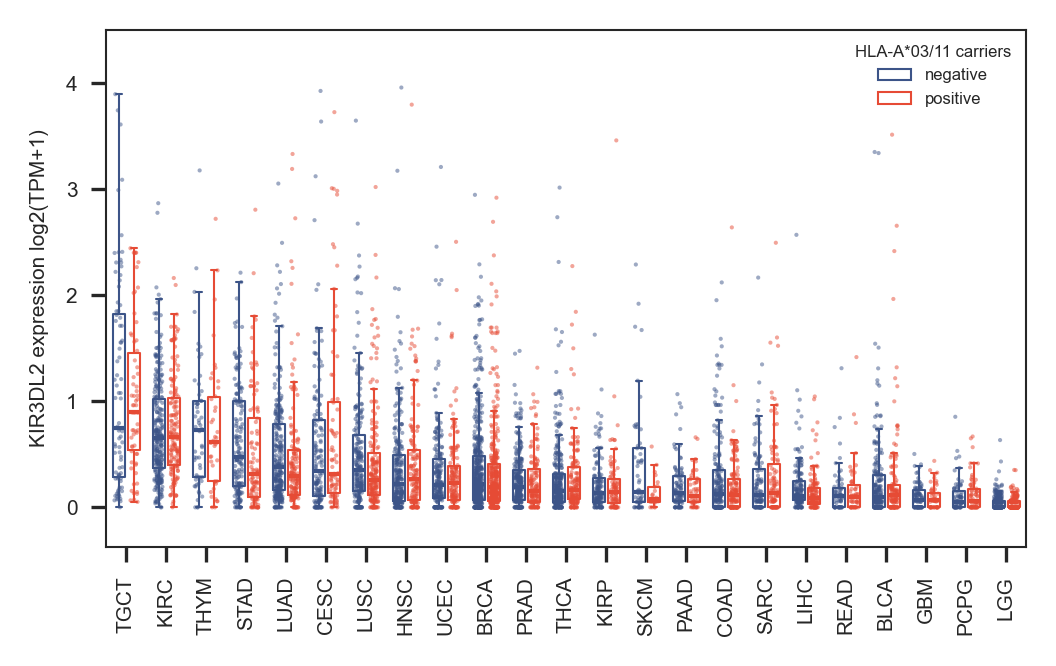

In [18]:
plt.figure(figsize=(3.5,2.2))
ax = sns.boxplot(data=HLA_A_IGSF8,
                 x="project_id",
                 order=HLA_A_IGSF8[["KIR3DL2", "project_id"]].groupby("project_id").median().sort_values("KIR3DL2", ascending=False).index,
                 y="KIR3DL2",
                 hue="A*03/11",
                 hue_order=["negative", "positive"],                 
                 palette={"positive": cmap.npg_palette(0), "negative": cmap.npg_palette(3)},
                 fill=False,
                 linecolor="#137",
                 linewidth=.5,
                 width=.75,
                 gap=0.2,
                 showfliers=False,
                 medianprops={'linewidth': 1},
                )

ax = sns.stripplot(data=HLA_A_IGSF8,
                   x="project_id",
                   order=HLA_A_IGSF8[["KIR3DL2", "project_id"]].groupby("project_id").median().sort_values("KIR3DL2", ascending=False).index,
                   y="KIR3DL2",
                   hue="A*03/11",
                   hue_order=["negative", "positive"],
                   palette={"positive": cmap.npg_palette(0), "negative": cmap.npg_palette(3)},
                   dodge=True,
                   s=1,
                   alpha=.5,
                   jitter=.2,
                   legend=False
                  )

ax.set_xlabel("")
ax.set_ylabel("KIR3DL2 expression log2(TPM+1)", fontsize=5)
ax.legend(loc="upper right", title="HLA-A*03/11 carriers",  title_fontsize=4, fontsize=4, frameon=False) #cols=1,
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(None, 4.5)
plt.savefig("../figures/FigS4G.pdf")

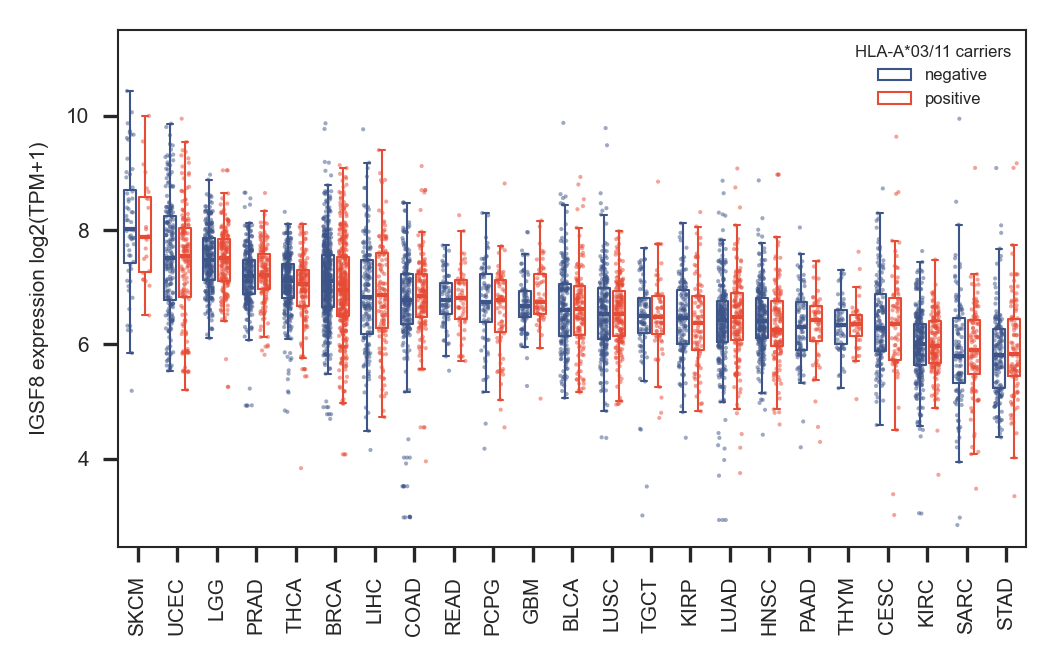

In [19]:
plt.figure(figsize=(3.5,2.2))
ax = sns.boxplot(data=HLA_A_IGSF8,
                 x="project_id",
                 order=HLA_A_IGSF8[["IGSF8", "project_id"]].groupby("project_id").median().sort_values("IGSF8", ascending=False).index,
                 y="IGSF8",
                 hue="A*03/11",
                 palette={"positive": cmap.npg_palette(0), "negative": cmap.npg_palette(3)},
                 hue_order=["negative", "positive"],
                 fill=False,
                 linecolor="#137",
                 linewidth=.5,
                 width=.75,
                 gap=0.2,
                 showfliers=False,
                 medianprops={'linewidth': 1},
                )

ax = sns.stripplot(data=HLA_A_IGSF8,
                   x="project_id",
                   order=HLA_A_IGSF8[["IGSF8", "project_id"]].groupby("project_id").median().sort_values("IGSF8", ascending=False).index,
                   y="IGSF8",
                   hue="A*03/11",
                   hue_order=["negative", "positive"],
                   palette={"positive": cmap.npg_palette(0), "negative": cmap.npg_palette(3)},
                   dodge=True,
                   s=1,
                   alpha=.5,
                   jitter=.2,
                   legend=False
                  )

ax.set_xlabel("")
ax.set_ylabel("IGSF8 expression log2(TPM+1)", fontsize=5)
ax.legend(loc="upper right", title="HLA-A*03/11 carriers",  title_fontsize=4, fontsize=4, frameon=False) #cols=1,
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylim(None, 11.5)
plt.savefig("../figures/FigS4H.pdf")

## Survival analysis with HLA allotype stratification

In [20]:
## Read HLAs
HLAs = pd.read_csv("../OncoMark/data/datasets/OptiTypeCallsHLA_20171207.tsv", index_col=8)
HLAs.index = ["-".join(idx.split("-")[:3]) for idx in HLAs.index]
HLAs = HLAs.iloc[:, :2]
HLAs["A1"] = [a1.split(":")[0] for a1 in HLAs["A1"].values]
HLAs["A2"] = [a1.split(":")[0] for a1 in HLAs["A2"].values]

HLAs = HLAs.rename_axis("submitter_id").reset_index().drop_duplicates().set_index("submitter_id")
HLAs["A"] = [natsorted([a1, a2]) if a1!=a2 else [a1]
             for a1, a2 in HLAs[["A1", "A2"]].values]
HLAs = HLAs.loc[~HLAs.index.duplicated()]

In [21]:
HLAs[["A"]].explode("A")

,A
submitter_id,
TCGA-DD-A1EI,A*30
TCGA-DD-A1EI,A*31
TCGA-39-5022,A*01
TCGA-39-5022,A*03
TCGA-KK-A7B1,A*11
...,...
TCGA-D8-A140,A*30
TCGA-B5-A1MY,A*02
TCGA-B5-A1MY,A*23


In [22]:
HLA_A03_mask = (HLAs[["A1", "A2"]] == "A*03").sum(axis=1)>0
HLA_A11_mask = (HLAs[["A1", "A2"]] == "A*11").sum(axis=1)>0

In [23]:
# Read RNAseq data
patient_data_TCGA = oma.data.load_tcga(file_path="../OncoMark/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                       metadata="../OncoMark/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                       filter_samples=100,
                                       sample_type="Tumor",
                                       genes=["IGSF8"])

2024-04-11 11:47:58|INFO|dataloader|Dropping duplicates...
2024-04-11 11:47:58|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2024-04-11 11:47:58|INFO|dataloader|Take Tumor samples only.
2024-04-11 11:47:58|INFO|dataloader|Take gene expression data of ['IGSF8']
2024-04-11 11:47:58|INFO|dataloader|Filtering out patients with < 100 samples...


In [24]:
# generate a dataframe to integrate expression data and metadata
expr_data = patient_data_TCGA.to_df().join(patient_data_TCGA.obs[["project_id", "samples.sample_type", "submitter_id", "cbioportal.subtype", "subtype(MSI)", "subtype(BRCA)", "subtype(SKCM)", "race"]])

# there are a few duplicated samples, likely processed by different analysts, we drop the duplicates and keep only the first entries
expr_data = expr_data[~expr_data["submitter_id"].duplicated()]

In [25]:
# read the clinical data of TCGA patient samples. Data was obtained from Liu et al, Cell (2018).
CDR = pd.read_excel("../OncoMark/data/datasets/TCGA-CDR_Liu2018.xlsx", index_col=1)

# annotate the stage according to the Liu et al, Cell (2018)
CDR.loc[CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'stage'] = CDR.loc[CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'clinical_stage']
CDR.loc[~CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'stage'] = CDR.loc[~CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'ajcc_pathologic_tumor_stage']

In [26]:
# Map the stage info into "early-stage" (1) and "late-stage" (2)
# We can also map it into 1, 2, 3, 4 as it is. The results are generally comparable, but some cohorts with few stage 4 tumors would run into issues.
mapper = {
    "Stage I": 1, "Stage IA": 1, "Stage IA1": 1, "Stage IA2": 1, "Stage IB": 1, "Stage IB1": 1, "Stage IB2": 1, "Stage IC": 1, "I/II NOS": 1,
    "Stage II": 1, "Stage IIA": 1, "Stage IIA1": 1, "Stage IIA2": 1, "Stage IIB": 1, "Stage IIC": 1,
    "Stage III": 2, "Stage IIIA": 2, "Stage IIIB": 2, "Stage IIIC": 2, "Stage IIIC1": 2, "Stage IIIC2": 2,
    "Stage IV": 2, "Stage IVA": 2, "Stage IVB": 2, "Stage IVC": 2
}

In [27]:
# Map the clinical info into expression data
expr_data["age"] = expr_data["submitter_id"].map(CDR["age_at_initial_pathologic_diagnosis"])
expr_data["gender"] = expr_data["submitter_id"].map(CDR["gender"])
expr_data["race"] = expr_data["submitter_id"].map(CDR["race"])
expr_data["stage"] = expr_data["submitter_id"].map(CDR["stage"].map(mapper))
expr_data["OS"] = expr_data["submitter_id"].map(CDR["OS"])
expr_data["OS.time"] = expr_data["submitter_id"].map(CDR["OS.time"])
expr_data["PFI"] = expr_data["submitter_id"].map(CDR["PFI"])
expr_data["PFI.time"] = expr_data["submitter_id"].map(CDR["PFI.time"])
expr_data["race"] = expr_data["race"].replace("[Unknown]", np.nan).replace("[Not Evaluated]", np.nan).replace("[Not Available]", np.nan)

In [28]:
# Add HLA-A*11 mask
expr_data["A03"] = expr_data["submitter_id"].map(HLA_A03_mask)
expr_data["A11"] = expr_data["submitter_id"].map(HLA_A11_mask)
expr_data["A03/11"] = expr_data["submitter_id"].map(HLA_A11_mask | HLA_A03_mask) # Split patients into A03/A11 carrier or A03/11 non-carrier

In [29]:
def divide_samples(df_input, divideby='IGSF8', cutoff='mean'):
    """
    divide TCGA samples by the `divideby` parameter according the parameter of `cutoff`
    """
    df = df_input.copy()
    if cutoff=="mean":
        df[f'{divideby}_group'] = np.sign(df[divideby] - df[divideby].mean())
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==1, "high")
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==-1, "low")

    elif cutoff=="median":
        df[f'{divideby}_group'] = np.sign(df[divideby] - df[divideby].median())
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==1, "high")
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==-1, "low")

    elif float(cutoff) < 1 and float(cutoff) >= 0.5:     

        cutoff1 = df[divideby].quantile(q=float(cutoff))
        cutoff2 = df[divideby].quantile(q=1-float(cutoff))

        df.loc[:, f'{divideby}_group'] = "intermediate"
        df.loc[:, f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[divideby]>cutoff1, "high").copy()
        df.loc[:, f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[divideby]<cutoff2, "low").copy()
        
    elif cutoff == 1:

        df.loc[:, f'{divideby}_group'] = "high"
        df.loc[:, f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[divideby]!=cutoff, "low").copy()

    high = df[df[f'{divideby}_group'] == "high"]
    low = df[df[f'{divideby}_group'] == "low"]
    
    return high, low, df

In [30]:
def get_four_subpopulations(input_df, divideby=["A03/11", "IGSF8"], cutoff=[1, ".75"]):
    """
    A helper function to divide patient samples into four subgroups
    """
    survival_subdata = input_df[input_df["OS.time"].notna()]
    div1_high, div1_low, _ = divide_samples(survival_subdata, divideby=divideby[0], cutoff=cutoff[0])
    
    div1_high_div2_high, div1_high_div2_low, _ = divide_samples(div1_high, divideby=divideby[1], cutoff=cutoff[1])
    div1_low_div2_high, div1_low_div2_low, _ = divide_samples(div1_low, divideby=divideby[1], cutoff=cutoff[1])
    
    return div1_high_div2_high, div1_high_div2_low, div1_low_div2_high, div1_low_div2_low

In [31]:
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

def logrank_p_value(data1, data2, event="OS", time="OS.time"):
    """
    calculate log rank p values
    """
    result = logrank_test(data1[time], data2[time],
                          data1[event], data2[event])
    return result.p_value

def cox_regression_p_value(survival_data, formula='age + gender + stage + race + IGSF8', event="OS", time="OS.time"): #   + cbioportal.subtype
    """
    Fit a cox regression model. Age, gender and stage are considered as covariates.
    """
    cph = CoxPHFitter(penalizer=0.5)#
    cols = formula.split(" + ") + [time, event]
    tmp = survival_data[cols].dropna()
    cph.fit(tmp, formula=formula, duration_col=time, event_col=event, robust=True)
    
    return cph.summary.loc["IGSF8", "p"], cph

In [32]:
# Calculate HR for all cohorts. Similar to the previous codes, but plotting is excluded.

coxs = []

for pid in [
    'KIRP', 'PAAD', 'BRCA', 'READ', 'UCEC',  
    'TGCT', 'THCA',  'KIRC', 'COAD',
    'STAD', 'SKCM', 'LUSC', 'HNSC', 'CESC', 'LIHC', 'LUAD', 'BLCA',
           ]:
    
    survival_subdata = expr_data.query('project_id==@pid')
    survival_subdata = survival_subdata[survival_subdata["OS.time"].notna()]
    div1_high, div1_low, _ = divide_samples(survival_subdata, divideby="IGSF8", cutoff=".75")
    
    # hypothesis testing for IGSF8-high and IGSF8-low groups within the MHCI-high population
    p_logrank = logrank_p_value(div1_high, div1_low, event="OS", time="OS.time")
    p_cox1, cox_res1 = cox_regression_p_value(pd.concat([div1_high, div1_low]), 
                                      formula='age + gender + stage + race + IGSF8', #
                                      event="OS", time="OS.time")
    p_cox2, cox_res2 = cox_regression_p_value(pd.concat([div1_high, div1_low]), 
                                      formula='age + gender + stage + race + A03 + A11 + IGSF8', #
                                      event="OS", time="OS.time")
    
    cox_res1 = cox_res1.summary.loc['IGSF8', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].to_frame("A*03/A*11 uncorrected").T
    cox_res1['sample_size'] = survival_subdata.shape[0]

    cox_res2 = cox_res2.summary.loc['IGSF8', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].to_frame("A*03/A*11 corrected").T
    cox_res2['sample_size'] = survival_subdata.shape[0]
    
    cox = pd.concat([cox_res1, cox_res2], axis=0)
    cox['project'] = pid
        
    coxs.append(cox)
    
coxs = pd.concat(coxs)

In [33]:
coxs

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,sample_size,project
A*03/A*11 uncorrected,1.093458,0.984910,1.213970,0.093950,289,KIRP
A*03/A*11 corrected,1.090790,0.982185,1.211404,0.104367,289,KIRP
A*03/A*11 uncorrected,0.906187,0.786061,1.044669,0.174566,178,PAAD
A*03/A*11 corrected,0.881217,0.766381,1.013259,0.075887,178,PAAD
A*03/A*11 uncorrected,0.996336,0.947961,1.047179,0.885057,1068,BRCA
A*03/A*11 corrected,0.996327,0.947569,1.047594,0.885701,1068,BRCA
A*03/A*11 uncorrected,1.172925,0.930284,1.478852,0.177387,165,READ
A*03/A*11 corrected,1.119847,0.892020,1.405862,0.329387,165,READ
A*03/A*11 uncorrected,0.994506,0.940549,1.051560,0.846529,544,UCEC
A*03/A*11 corrected,0.965011,0.908903,1.024582,0.243872,544,UCEC


In [34]:
# target the cohorts of significance
coxs = coxs.query('sample_size>20')
coxs = coxs.rename_axis("HLA_adjusted").reset_index()
coxs['ci'] = (coxs['exp(coef) upper 95%'] - coxs['exp(coef) lower 95%']) / 2

# manipulate the dataframe
coxs1 = coxs.set_index(["project", "HLA_adjusted"]).unstack()
coxs1.columns = coxs1.columns.swaplevel()
coxs1 = coxs1.sort_index(axis=1)

MHCI_high_HR = coxs1[['A*03/A*11 uncorrected']].sort_values(("A*03/A*11 uncorrected", "exp(coef)")).reset_index()
MHCI_low_HR = coxs1[['A*03/A*11 corrected']].reindex(MHCI_high_HR['project']).reset_index()

In [35]:
# set markers for different groups, MHCI-high and MHCI-low

errorbar_kwargs_low = {"c": cmap.npg_palette(3),
                       "fmt": "s",
                       "markersize": 3,
                       "markerfacecolor": cmap.npg_palette(3),
                       "markeredgewidth": .5,
                       "capsize": 1.,
                       "elinewidth": .5
                      }

errorbar_kwargs_high = {"c": cmap.npg_palette(0),
                        "fmt": "s",
                        "markersize": 3,
                        "markerfacecolor": cmap.npg_palette(0),
                        "markeredgewidth": .5,
                        "capsize": 1.,
                        "elinewidth": .5
                       }

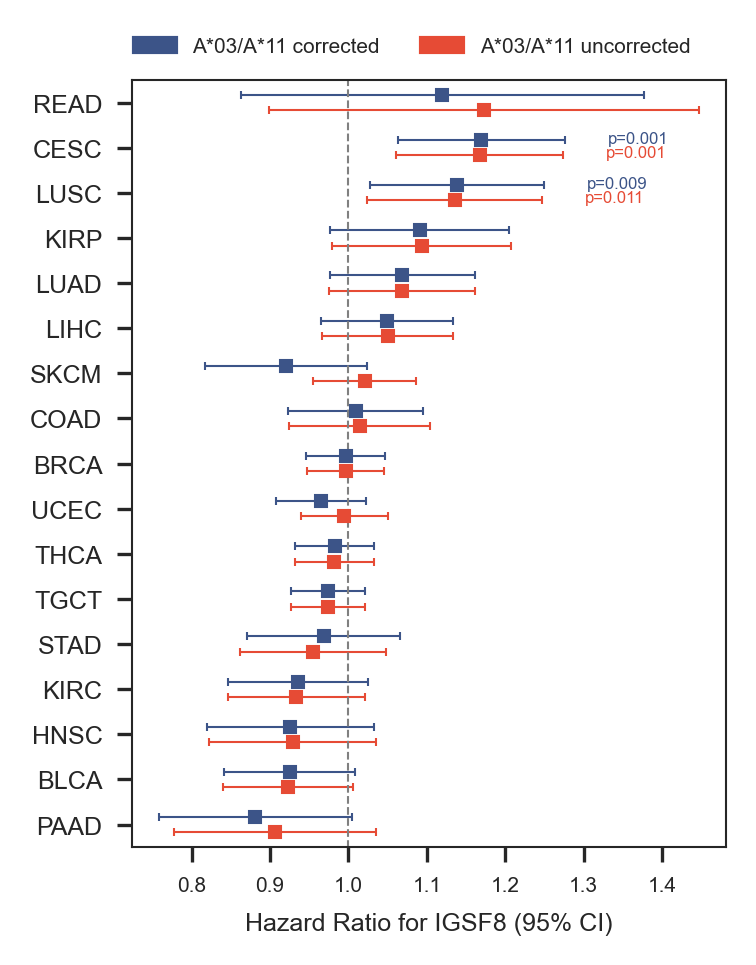

In [36]:
# plotting

from matplotlib.patches import Patch

plt.figure(figsize = (2.5, 3.2));
plt.errorbar(MHCI_low_HR['A*03/A*11 corrected']["exp(coef)"], MHCI_low_HR.index + .17, xerr=MHCI_low_HR['A*03/A*11 corrected']["ci"], **errorbar_kwargs_low);
plt.errorbar(MHCI_high_HR['A*03/A*11 uncorrected']["exp(coef)"], MHCI_high_HR.index - .17, xerr=MHCI_high_HR['A*03/A*11 uncorrected']["ci"], **errorbar_kwargs_high);

[plt.text(row["exp(coef) upper 95%"] + .05, idx + .1, f"p={row['p']:.3f}", fontsize=4, c=cmap.npg_palette(3)) for idx, row in MHCI_low_HR['A*03/A*11 corrected'].iterrows() if row['p']<.05]
[plt.text(row["exp(coef) upper 95%"] + .05, idx - .2, f"p={row['p']:.3f}", fontsize=4, c=cmap.npg_palette(0)) for idx, row in MHCI_high_HR['A*03/A*11 uncorrected'].iterrows() 
 if row['p']<.05 and row["exp(coef) upper 95%"]<5]

[plt.text(row["exp(coef) upper 95%"] - 2, idx + .05, f"p={row['p']:.3f}", fontsize=4, c=cmap.npg_palette(0)) for idx, row in MHCI_high_HR['A*03/A*11 uncorrected'].iterrows() 
 if row['p']<.05 and row["exp(coef) upper 95%"]>5]

plt.vlines(1, -1., 16.5, ls="--", lw=.5, color='gray')
plt.yticks(MHCI_high_HR.index, MHCI_high_HR['project'].values, fontsize=6)
plt.ylim(-.5, 16.5)
# plt.xlim(-3.5, 20.)
plt.xlabel("Hazard Ratio for IGSF8 (95% CI)", fontsize=6)

handles = [
    Patch(edgecolor=color, facecolor=color, label=label) 
    for label, color in zip(['A*03/A*11 corrected', 'A*03/A*11 uncorrected'], [cmap.npg_palette(3), cmap.npg_palette(0)])
]
plt.legend(handles=handles, loc=(-0.01, 1.02), ncols=2, fontsize=5, frameon=False);

plt.savefig("../figures/FigS4J.pdf", bbox_inches = "tight")